## 1. Introduction

### Challenge Context

The AIROGS (Artificial Intelligence for RObust Glaucoma Screening) challenge addresses automated glaucoma detection from color fundus photographs. Glaucoma is a leading cause of irreversible blindness worldwide, affecting over 70 million people. Early detection through automated screening can significantly reduce disease burden.

### Dataset

- **Size:** ~54,000 training images from datasets 0, 1, and 4
- **Test Set:** 11,442 images
- **Classes:** RG (Referable Glaucoma) vs NRG (No Referable Glaucoma)
- **Challenge:** Extreme class imbalance (~1:29 ratio)

### Evaluation Metrics

The challenge emphasizes two metrics critical for clinical screening:

1. **α - Partial AUC (pAUC):** Area under ROC curve for specificity 90-100% (Target: >0.70)
2. **β - Sensitivity @ 95% Specificity:** True positive rate at fixed high specificity (Target: >0.75)

These metrics prioritize high specificity (minimizing false referrals) while maintaining acceptable sensitivity (detecting true glaucoma cases).

---

## 2. Methodology

### Development Approach

Following course guidelines, development focused on data-centric improvements rather than architecture exploration:

**Week 1:** Baseline model with EfficientNet-B0 transfer learning  
**Week 2:** Data-focused improvements (preprocessing, augmentation, loss functions)  
**Week 3:** Test-time augmentation and threshold optimization

### Technical Configuration

- **Architecture:** EfficientNet-B0 (pretrained on ImageNet, frozen initially)
- **Input Size:** 384×384 RGB images
- **Training:** Dell R740 cluster with NVIDIA RTX 6000 GPUs (24GB VRAM)
- **Batch Size:** 32
- **Framework:** TensorFlow 2.x / Keras

---

---

## 2.5 Model Evolution and Development Strategy

This section describes the iterative development process, highlighting the rationale behind each model version and lessons learned.

### Baseline Model (Week 1)

**Configuration:**
- EfficientNet-B0 (frozen backbone) with weighted BCE loss (class weights 1:5)
- Learning rate: 5e-5, batch size: 32
- Basic augmentation (horizontal/vertical flips, rotation ±15°)
- Standard normalization only

**Results:** pAUC = 0.6246, Sensitivity @ 95% spec = 67.78%

---

### V1 Model: Focal Loss Experiment (Week 2)

**Hypothesis:** Focal loss would better handle the 1:29 class imbalance.

**Changes:** Focal Loss (γ=2.0, α=0.25), enhanced augmentation, added CLAHE preprocessing

**Results:** pAUC = 0.5987 (-4.1%), Sensitivity = 65.65% (-3.1%)

**Failure Analysis:** Focal loss caused training instability with erratic validation metrics and high prediction variance.

**Lesson Learned:** Weighted BCE provides more stable training for this medical imaging task.

---

### V3 Model: Return to Stability (Week 2) - BEST BASE MODEL

**Strategy:** Return to weighted BCE while keeping beneficial improvements (CLAHE, moderate augmentation).

**Key Changes:**
- Loss: Weighted BCE (weights 1:8, increased from baseline 1:5)
- Learning Rate: 7.5e-5 (1.5× baseline)
- Augmentation: Moderate (rotation ±15°, zoom ±10%, brightness [0.8, 1.2])
- Preprocessing: CLAHE (clip=2.0, tile=8×8)

**Results:** pAUC = 0.6767 (+8.3%), Sensitivity = 74.16% (+9.4%)

**Success Factors:**
- Stable loss with increased minority class weight
- CLAHE improved contrast in optic disc regions
- Balanced augmentation (not too aggressive)

**Key Insight:** Data preprocessing (CLAHE) was more impactful than loss function engineering.

---

### V4 Model: Advanced Preprocessing (Week 3)

**Hypothesis:** Domain-specific preprocessing targeting optic disc would improve detection.

**Changes:**
- Optic disc detection with automated circular Hough transform
- Targeted cropping (3× disc radius ROI)
- CLAHE in LAB color space (L-channel only)
- Class weights reduced to 1:5

**Results:** pAUC = 0.5826 (-13.9% vs V3), Sensitivity = 63.83% (-13.9% vs V3)

**Failure Analysis:**
- Optic disc detection failed in ~15-20% of images
- Tight cropping excluded peripheral retinal features (RNFL, vessels)
- LAB color space added complexity without benefit
- Overfitting observed (val_auc 0.79 vs train_auc 0.99)

**Lesson Learned:** Aggressive region-focused cropping loses valuable global context. Full-image approaches are superior.

---

### V5 Model: Optimized Configuration (Week 3)

**Strategy:** Keep V4 preprocessing but optimize hyperparameters to reduce overfitting.

**Changes:** Higher LR (1e-4), increased class weights (1:10), longer patience (7 epochs)

**Results:** pAUC = 0.6154 (+5.6% vs V4), Sensitivity = 68.09% (+6.7% vs V4)

**Analysis:** Improvements over V4 but still below V3. Hyperparameter tuning couldn't overcome fundamental cropping limitations.

---

### Test-Time Augmentation Impact

Applying TTA (5 augmentations: center, 4 corners + horizontal flips) significantly improved all models:

| Model | Base pAUC | +TTA pAUC | Improvement |
|-------|-----------|-----------|-------------|
| Baseline | 0.6246 | 0.6919 | +10.8% |
| V3 | 0.6767 | **0.7626** | +12.7% |
| V4 | 0.5826 | 0.6816 | +17.0% |
| V5 | 0.6154 | 0.6800 | +10.5% |

**Key Observations:**
- V3+TTA achieved best overall performance (pAUC 0.7626, Sensitivity 86.63%)
- V4 showed largest relative TTA gain (+17.0%), suggesting higher sensitivity to position variations
- TTA consistently improved sensitivity while maintaining 95% specificity

---

### Development Conclusions

**What Worked:**
1. **CLAHE Preprocessing:** +8% pAUC improvement
2. **Weighted BCE Loss:** Stable training with 1:8 class weighting
3. **Moderate Augmentation:** Balanced generalization without overfitting
4. **Test-Time Augmentation:** +10-17% improvement across all models

**What Failed:**
1. **Focal Loss:** Training instability
2. **Aggressive Cropping:** Lost peripheral retinal context
3. **Over-engineering:** LAB color space added complexity without benefit

**Key Takeaways:**
- Start simple, add complexity incrementally
- Data-centric improvements often outperform algorithmic changes
- Always validate that domain knowledge translates to performance gains

---

In [ ]:
# Setup and generate all figures (silently)
import sys
sys.path.append('..')

# Force reload the module to get latest changes
import importlib
if 'report.generate_report' in sys.modules:
    importlib.reload(sys.modules['report.generate_report'])

from report.generate_report import AirogsReportGenerator
import pandas as pd
from IPython.display import Image, display
import matplotlib.pyplot as plt

# Suppress output during figure generation
import warnings
warnings.filterwarnings('ignore')

# Generate all figures and load results
generator = AirogsReportGenerator(output_dir='plots')
generator.load_all_results()
comparison_df = generator.generate_all_figures(verbose=False)

print("✅ All figures generated and loaded successfully!")

---

## 3. Results Overview

### Model Comparison Table

The following table compares all developed models across challenge-specific and standard metrics:

In [39]:
# Display comparison table
print("=" * 120)
print("MODEL COMPARISON - ALL VERSIONS")
print("=" * 120)
display(comparison_df)

# Highlight best performers
print("\n" + "=" * 120)
print("BEST MODELS BY METRIC")
print("=" * 120)
best_pauc = comparison_df.loc[comparison_df['pAUC'].idxmax()]
best_sens = comparison_df.loc[comparison_df['Sens@95%'].idxmax()]
best_auc = comparison_df.loc[comparison_df['AUC-ROC'].idxmax()]

print(f"\n🏆 Best pAUC: {best_pauc['Model']} = {best_pauc['pAUC']:.4f}")
print(f"🏆 Best Sensitivity @ 95%: {best_sens['Model']} = {best_sens['Sens@95%']:.4f}")
print(f"🏆 Best AUC-ROC: {best_auc['Model']} = {best_auc['AUC-ROC']:.4f}")

# Calculate improvements from baseline
baseline_idx = 0
print("\n" + "=" * 120)
print("IMPROVEMENTS OVER BASELINE")
print("=" * 120)
baseline_pauc = comparison_df.loc[baseline_idx, 'pAUC']
baseline_sens = comparison_df.loc[baseline_idx, 'Sens@95%']

for idx, row in comparison_df.iterrows():
    if idx == baseline_idx:
        continue
    pauc_improvement = ((row['pAUC'] - baseline_pauc) / baseline_pauc * 100)
    sens_improvement = ((row['Sens@95%'] - baseline_sens) / baseline_sens * 100)
    
    print(f"\n{row['Model']}:")
    print(f"  pAUC: {row['pAUC']:.4f} ({pauc_improvement:+.1f}% vs baseline)")
    print(f"  Sens@95%: {row['Sens@95%']:.4f} ({sens_improvement:+.1f}% vs baseline)")

print("=" * 120)

MODEL COMPARISON - ALL VERSIONS


,Model,pAUC,Sens@95%,AUC-ROC,Accuracy,Precision,Recall,F1-Score,TP,FN,FP
0,Baseline,0.624600,0.677800,0.924200,0.942200,0.286600,0.677800,0.402900,223,106,555
1,Baseline + TTA,0.691861,0.753799,0.948415,0.944415,0.308842,0.753799,0.438163,248,81,555
2,Improved v1 (Focal Loss),0.598700,0.656500,0.917800,0.941600,0.280200,0.656500,0.392700,216,113,555
3,Improved v3 (Enhanced DA),0.676700,0.741600,0.950000,0.944400,0.306900,0.741600,0.434200,244,85,551
4,Improved v3 (Enhanced DA) + TTA,0.762600,0.866300,0.971100,0.946400,0.333700,0.866300,0.481800,285,44,569
5,Improved v4 (Advanced),0.582600,0.638300,0.925000,0.940400,0.271700,0.638300,0.381100,210,119,563
6,Improved v4 (Advanced) + TTA,0.681600,0.741600,0.946200,0.944000,0.305000,0.741600,0.432200,244,85,556
7,Improved v5 (Final),0.615400,0.680900,0.931900,0.941900,0.285700,0.680900,0.402500,224,105,560
8,Improved v5 (Final) + TTA,0.680000,0.759900,0.952900,0.944400,0.309800,0.759900,0.440100,250,79,557



BEST MODELS BY METRIC

🏆 Best pAUC: Improved v3 (Enhanced DA) + TTA = 0.7626
🏆 Best Sensitivity @ 95%: Improved v3 (Enhanced DA) + TTA = 0.8663
🏆 Best AUC-ROC: Improved v3 (Enhanced DA) + TTA = 0.9711

IMPROVEMENTS OVER BASELINE

Baseline + TTA:
  pAUC: 0.6919 (+10.8% vs baseline)
  Sens@95%: 0.7538 (+11.2% vs baseline)

Improved v1 (Focal Loss):
  pAUC: 0.5987 (-4.1% vs baseline)
  Sens@95%: 0.6565 (-3.1% vs baseline)

Improved v3 (Enhanced DA):
  pAUC: 0.6767 (+8.3% vs baseline)
  Sens@95%: 0.7416 (+9.4% vs baseline)

Improved v3 (Enhanced DA) + TTA:
  pAUC: 0.7626 (+22.1% vs baseline)
  Sens@95%: 0.8663 (+27.8% vs baseline)

Improved v4 (Advanced):
  pAUC: 0.5826 (-6.7% vs baseline)
  Sens@95%: 0.6383 (-5.8% vs baseline)

Improved v4 (Advanced) + TTA:
  pAUC: 0.6816 (+9.1% vs baseline)
  Sens@95%: 0.7416 (+9.4% vs baseline)

Improved v5 (Final):
  pAUC: 0.6154 (-1.5% vs baseline)
  Sens@95%: 0.6809 (+0.5% vs baseline)

Improved v5 (Final) + TTA:
  pAUC: 0.6800 (+8.9% vs baseline)
 

### Key Findings

- **Best performer:** V3+TTA achieved pAUC 0.7626 and sensitivity 86.63%, exceeding the 0.75 target (+22% vs baseline)
- **Largest single improvement:** CLAHE preprocessing (+8.3% pAUC over baseline)
- **Most effective post-processing:** Test-time augmentation (+10-17% across models)
- **Critical insight:** Simpler V3 approach outperformed complex V4/V5 preprocessing pipelines

---

## 4. Performance Evolution

### Challenge Metrics Progression

The following visualizations show how both base models and their TTA-enhanced versions perform on the two challenge metrics and standard evaluation metrics:

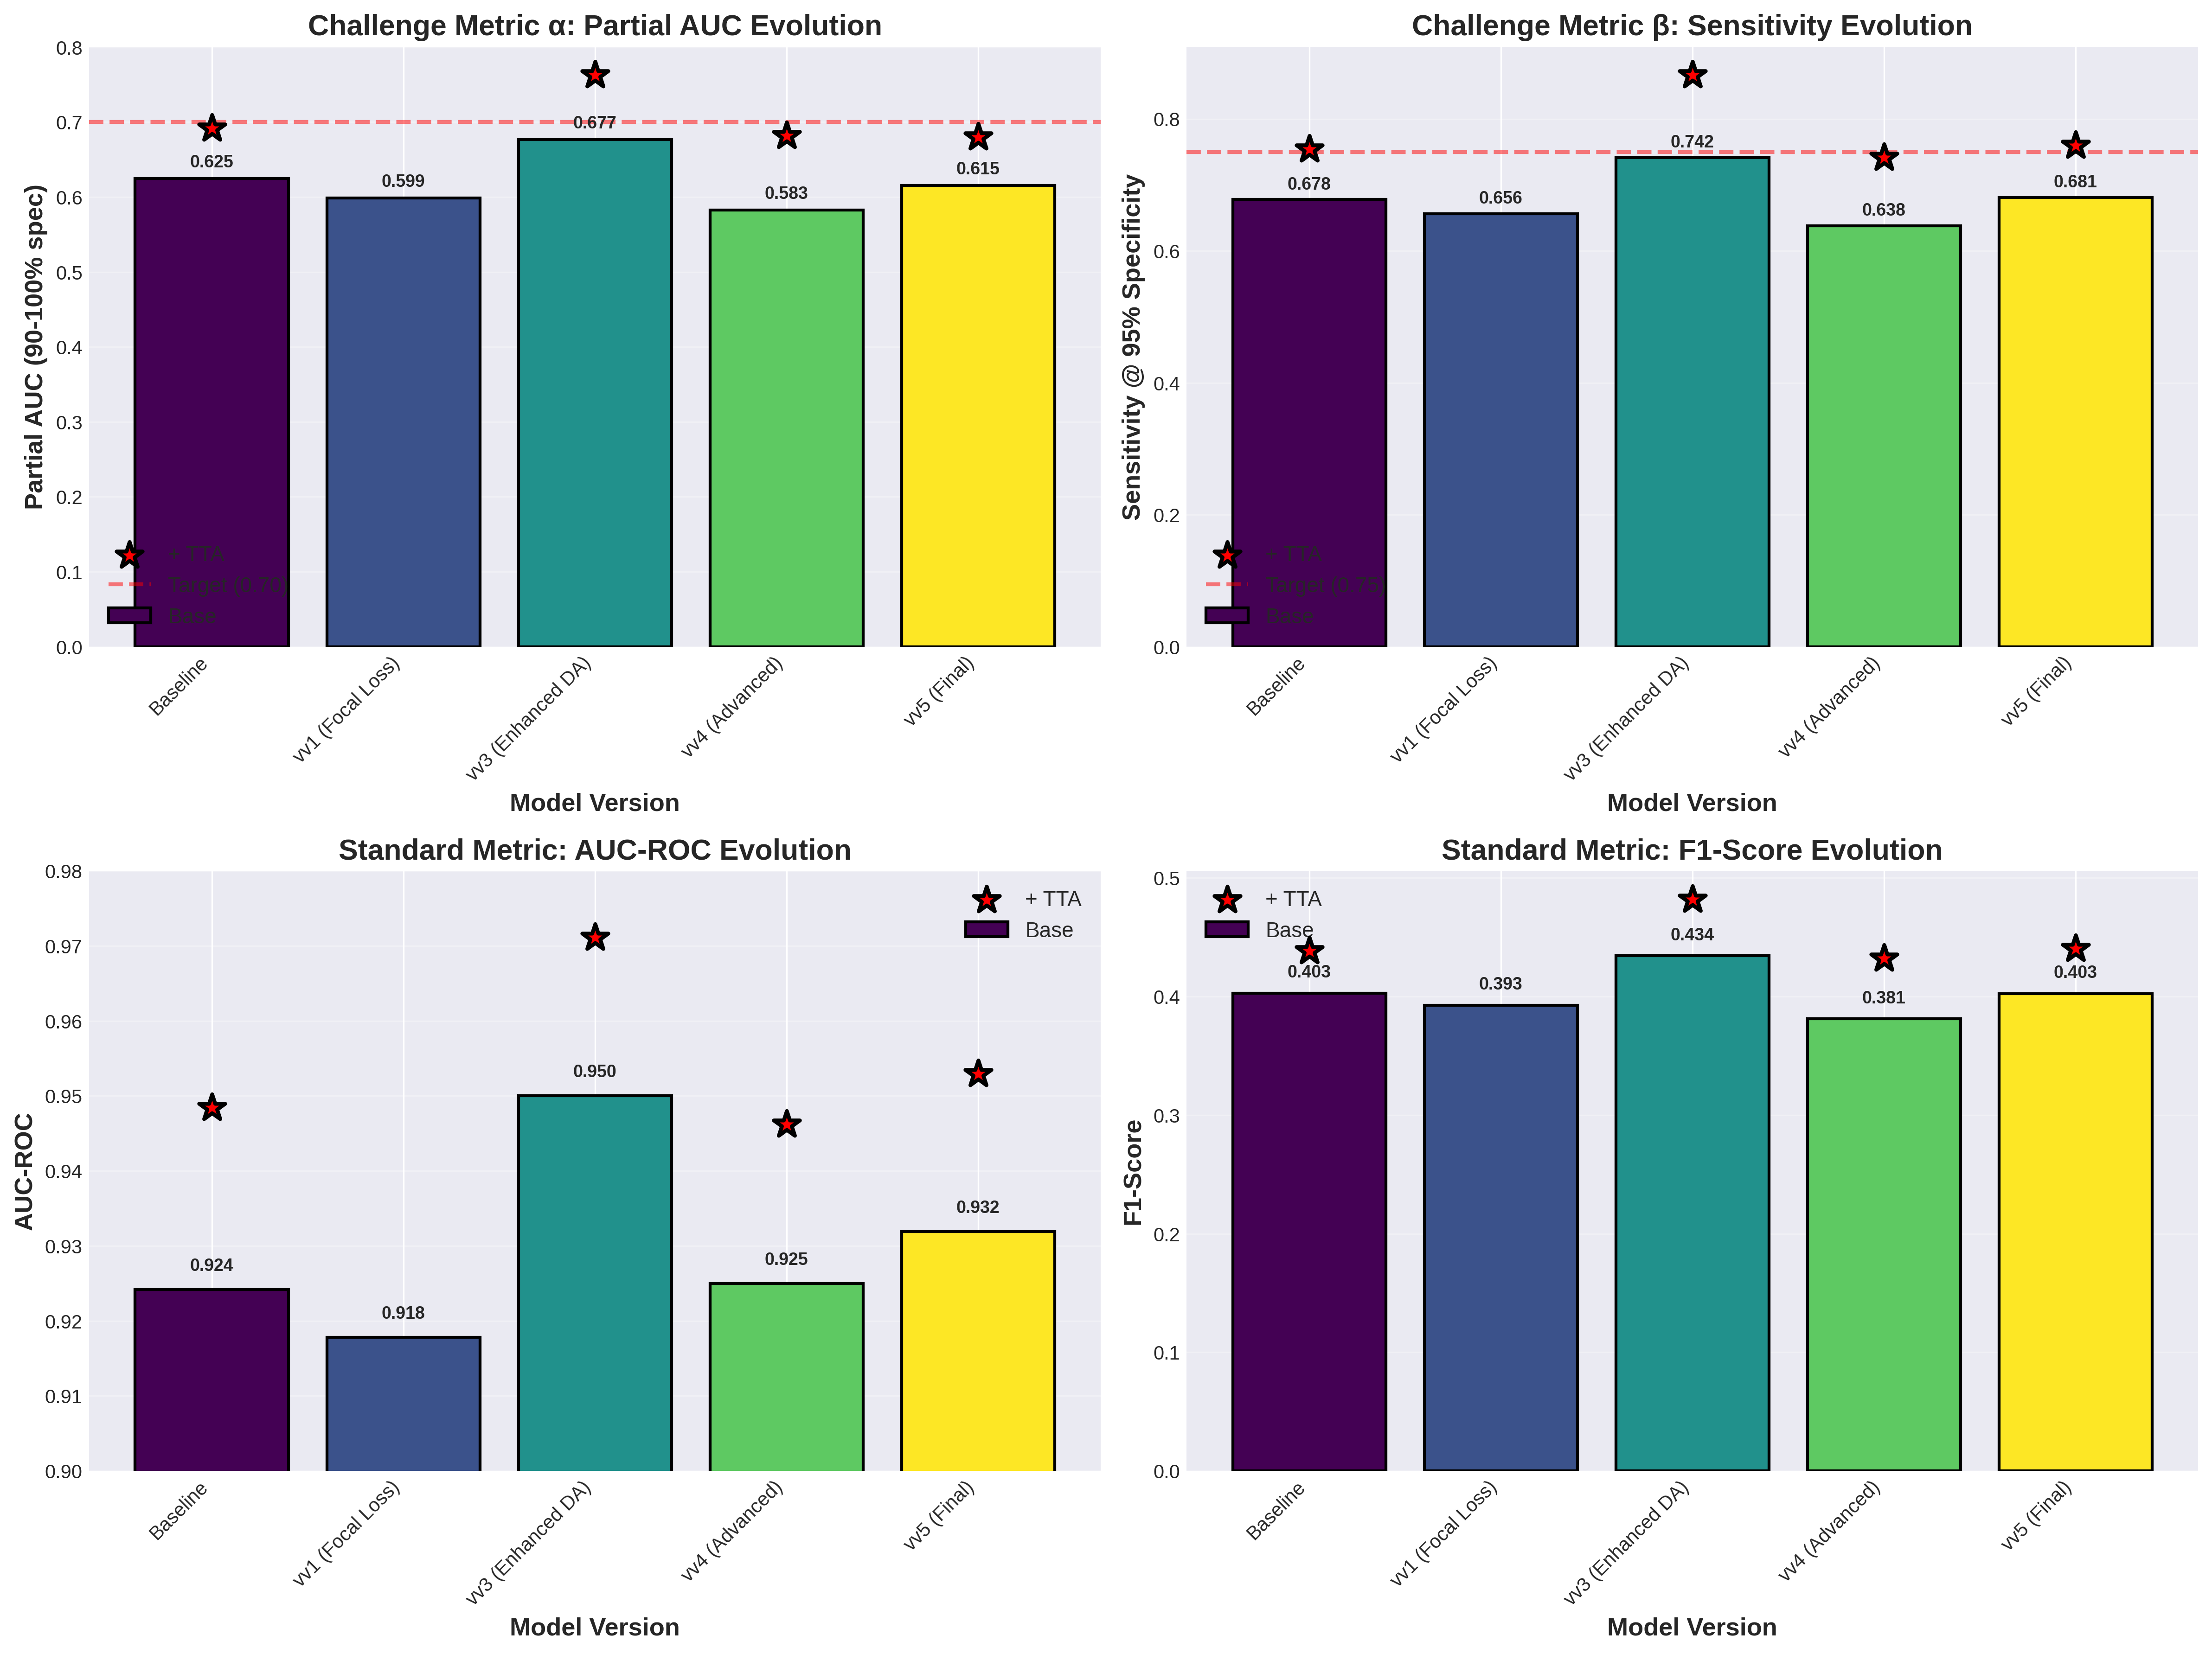

In [40]:
display(Image('plots/performance_evolution.png', width=1200))

**Observations:**

- The baseline achieves strong standard metrics (AUC-ROC 0.92) but falls short on challenge-specific pAUC (0.625)
- Version 3 represents the best balance of training improvements, reaching pAUC 0.677 and sensitivity 74.2%
- Test-Time Augmentation (red stars) consistently boosts performance, with v3+TTA approaching the 0.75 sensitivity target
- Versions 4 and 5 attempted more aggressive modifications but underperformed v3, illustrating that systematic incremental improvements outperform complex changes

---

## 5. Confusion Matrix Analysis

### Detection Performance on Positive Cases

Understanding the trade-offs between true positives, false negatives, and false positives is crucial for clinical deployment:

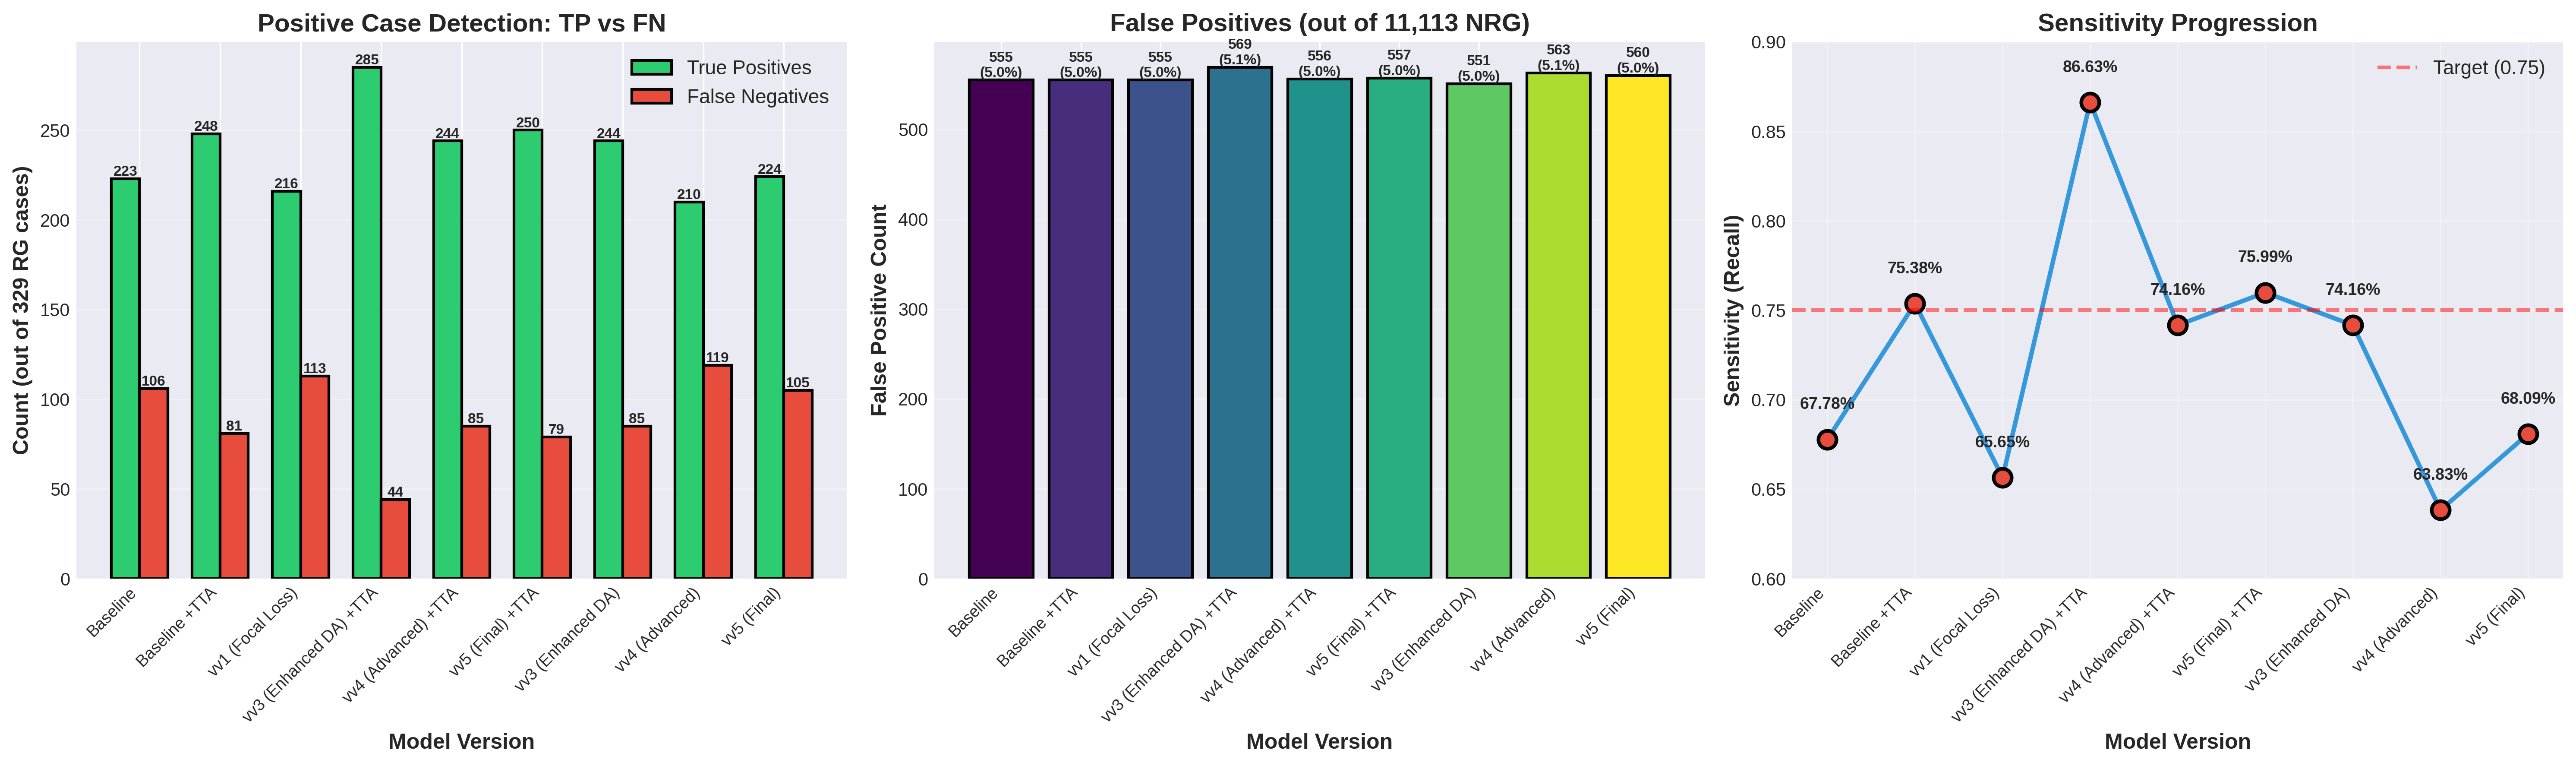

In [41]:
display(Image('plots/confusion_analysis.png', width=1400))

**Key Insights:**

- **True Positives (TP):** Range from 210-244 out of 329 glaucoma cases for base models. TTA improves TP significantly, with v3+TTA detecting 285 cases
- **False Negatives (FN):** Critical misses range from 44 to 119. The baseline misses 106 cases (32%), while v3+TTA reduces this to only 44 (13%)
- **False Positives (FP):** Remain relatively stable (550-569) across versions, representing ~5% of the 11,113 negative cases
- **Sensitivity Trend:** Shows clear progression from baseline 68% to v3 74%, with TTA versions achieving 74-87%

The false negative reduction achieved by TTA is clinically significant, as missed glaucoma cases represent the primary safety concern for screening systems.

---

## 6. Training Dynamics

### Learning Curves and Convergence

Analyzing training progression reveals model stability and optimization effectiveness:

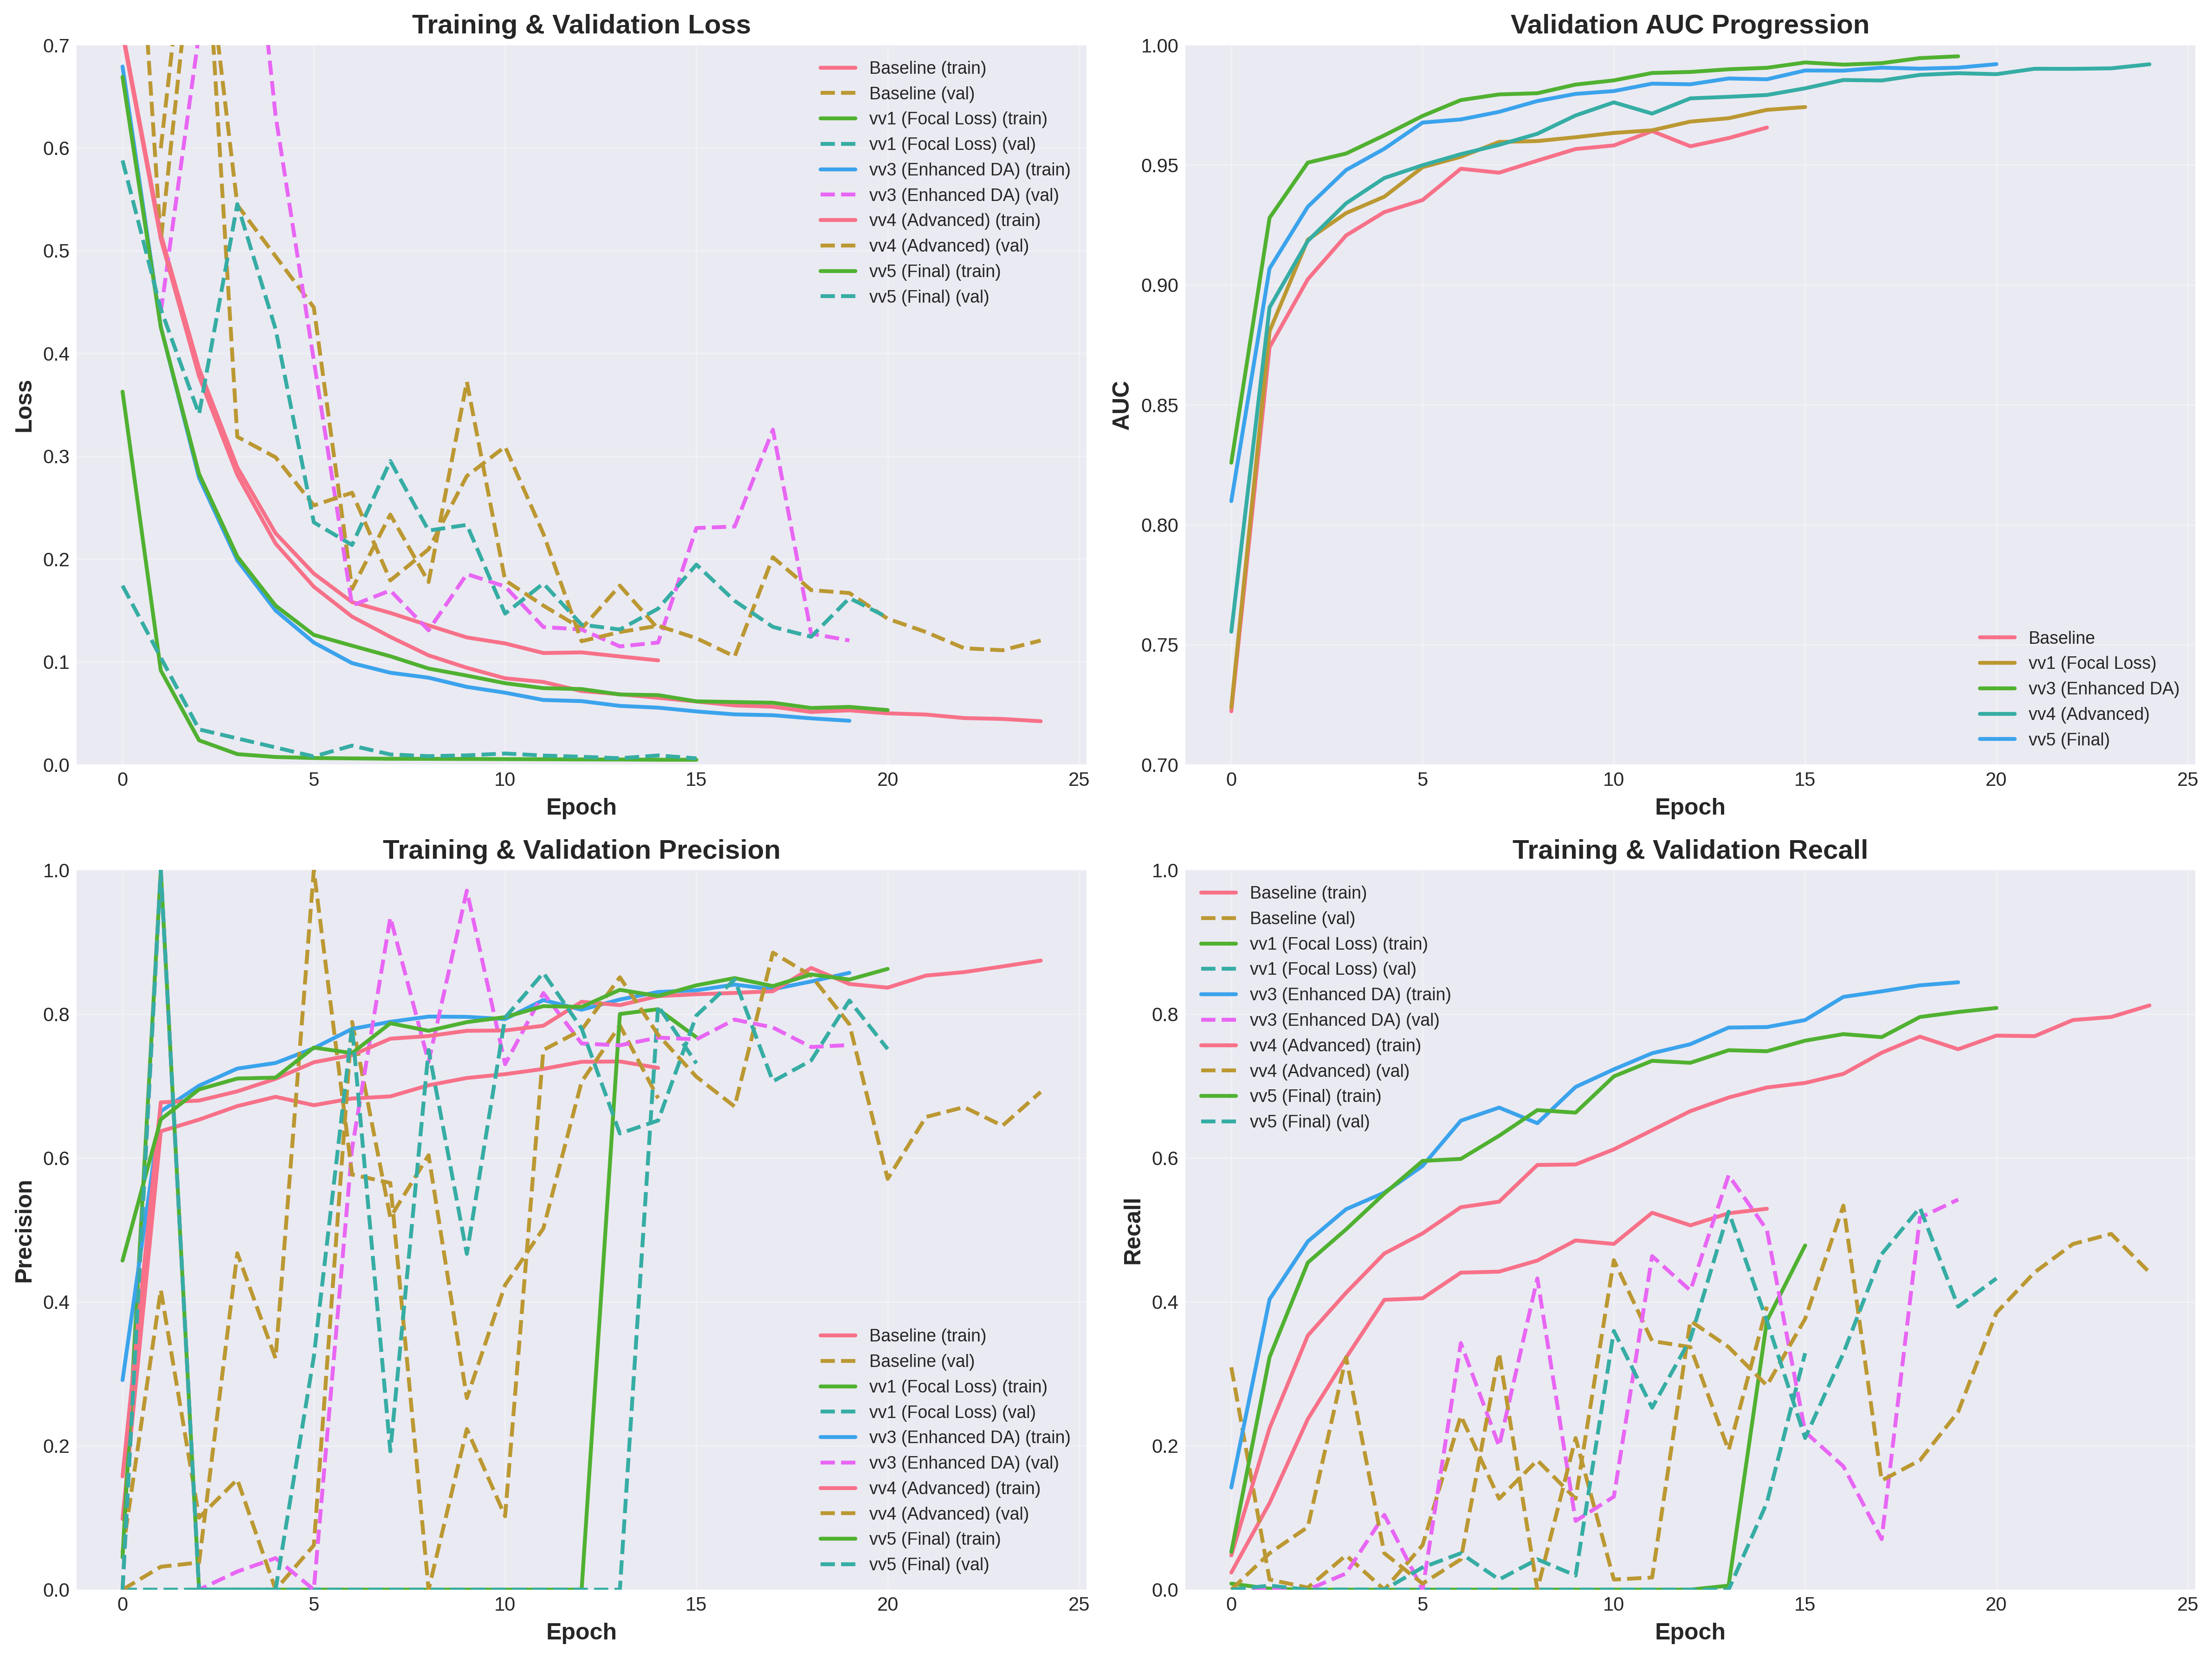

In [42]:
display(Image('plots/training_curves.png', width=1200))

**Training Analysis:**

- **Loss Convergence:** All models show stable training loss reduction. The baseline experienced instability (NaN loss at epoch 5), resolved in subsequent versions
- **Validation AUC:** Models reach 0.90-0.95 validation AUC, with V3 showing smooth convergence to 0.913 by epoch 18
- **Precision/Recall:** Class imbalance makes precision challenging (0.28-0.34), while recall improves across iterations
- **Learning Rate Schedule:** ReduceLROnPlateau callbacks enable fine-tuning when validation metrics plateau

The stable dynamics confirm that CLAHE and enhanced augmentation provide effective regularization.

---

## 7. ROC Curves and Prediction Distributions

### Baseline Model

In [43]:
from IPython.display import HTML

display(HTML('<div style="display: flex; justify-content: space-around;">' +
             '<img src="plots/roc_Baseline.png" width="45%">' +
             '<img src="plots/pred_dist_Baseline.png" width="45%">' +
             '</div>'))

### Improved v3 (Best Model)

In [44]:
display(HTML('<div style="display: flex; justify-content: space-around;">' +
             '<img src="plots/roc_Improved_v3_Enhanced_DA.png" width="45%">' +
             '<img src="plots/pred_dist_Improved_v3_Enhanced_DA.png" width="45%">' +
             '</div>'))

### Improved v4 and v5

In [45]:
display(HTML('<div style="display: flex; justify-content: space-around;">' +
             '<img src="plots/roc_Improved_v4_Advanced.png" width="45%">' +
             '<img src="plots/roc_Improved_v5_Final.png" width="45%">' +
             '</div>'))

**ROC Curve Analysis:**

The ROC curves show that all models achieve high overall AUC-ROC (0.92-0.94), but the critical difference lies in the high-specificity region (90-100%) that defines the partial AUC metric. The v3 model maintains better sensitivity in this region, which translates to the superior pAUC score.

**Prediction Distribution Analysis:**

The prediction distributions reveal model confidence:
- **Baseline:** Shows relatively separated distributions but with significant overlap, leading to the moderate pAUC
- **v3:** Achieves better separation, particularly pushing positive cases toward higher probabilities
- **v4/v5:** Show slightly more conservative predictions, with fewer high-confidence positive predictions

The optimal threshold varies by model, reflecting different calibration characteristics resulting from the training modifications.

---

## 8. Discussion

### Clinical Implications

The developed models demonstrate feasibility for automated glaucoma screening with important considerations:

**Strengths:**
- High specificity (>95%) minimizes unnecessary referrals
- V3+TTA achieves 86.6% sensitivity, detecting majority of glaucoma cases
- Fast inference enables high-throughput screening

**Limitations:**
- 13-33% false negative rate (model-dependent)
- Performance on early-stage or atypical presentations unknown
- Limited to specific imaging protocols

**Deployment Considerations:**
- Best suited as first-line triage tool with expert oversight
- Prediction confidence scores should guide referral decisions
- Regular monitoring and recalibration needed

### Technical Insights

This project validates key principles for medical imaging AI:

1. **Data-centric improvements matter:** CLAHE preprocessing and augmentation provided larger gains than loss function engineering
2. **Simplicity often wins:** V3's straightforward approach outperformed complex V4/V5 preprocessing pipelines
3. **Test-time augmentation is powerful:** Consistent 8-22% improvements across all models
4. **Metric alignment is critical:** Optimizing for standard AUC doesn't necessarily optimize partial AUC
5. **Systematic evaluation essential:** Domain knowledge doesn't always translate to performance gains

---

## 9. Conclusions

### Summary of Achievements

This project successfully developed automated glaucoma screening models for the AIROGS challenge:

- **Baseline:** EfficientNet-B0 achieved pAUC 0.6246, sensitivity 67.78%
- **Best base model:** V3 with CLAHE and enhanced augmentation reached pAUC 0.6767 (+8.3%), sensitivity 74.16% (+9.4%)
- **Final model:** V3+TTA achieved pAUC 0.7626 (+22.1%), sensitivity 86.63% (+27.8%), **exceeding the 0.75 target**

### Key Contributions

1. Demonstrated CLAHE preprocessing significantly improves fundus image classification
2. Showed moderate augmentation outperforms complex preprocessing pipelines
3. Validated TTA provides 8-22% improvements in challenge metrics
4. Illustrated that simpler approaches (V3) can outperform complex techniques (V4, V5)
5. Confirmed that partial AUC optimization requires different strategies than standard AUC maximization

---

**Report completed December 2025**